# Iris Classification
Iris Classification using a Neural Network model

Let's first import the required libraries.

In [789]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
np.random.seed(1) # For replication of the models

assert tf.__version__ == '1.1.0'
assert np.version.version == '1.12.1'

Now let's look at the what the data looks like. How about the first 5 rows?

In [790]:
df = pd.read_csv('data/iris_train.csv')
print("Shape: ", df.shape)
print("Columns: ", df.columns)
print("Labels: ", df.labels.unique())
df.head(5)

Shape:  (110, 6)
Columns:  Index(['Unnamed: 0', '0', '1', '2', '3', 'labels'], dtype='object')
Labels:  ['Iris-virginica' 'Iris-versicolor' 'Iris-setosa']


,Unnamed: 0,0,1,2,3,labels
0,0,6.3,2.9,5.6,1.8,Iris-virginica
1,1,5.6,3.0,4.5,1.5,Iris-versicolor
2,2,7.9,3.8,6.4,2.0,Iris-virginica
3,3,6.5,2.8,4.6,1.5,Iris-versicolor
4,4,5.0,2.0,3.5,1.0,Iris-versicolor


From the shape, it looks like there are 110 records in the dataset

There are 3 types of classes - `Iris-virginica`, `Iris-versicolor`, `Iris-setosa` 

Let's drop the first column since we don't need it

In [791]:
df_clean = df.drop(columns=['Unnamed: 0'])
df_clean.head(5)

,0,1,2,3,labels
0,6.3,2.9,5.6,1.8,Iris-virginica
1,5.6,3.0,4.5,1.5,Iris-versicolor
2,7.9,3.8,6.4,2.0,Iris-virginica
3,6.5,2.8,4.6,1.5,Iris-versicolor
4,5.0,2.0,3.5,1.0,Iris-versicolor


Now let's visualize that data in multiple 2D scatter plots.

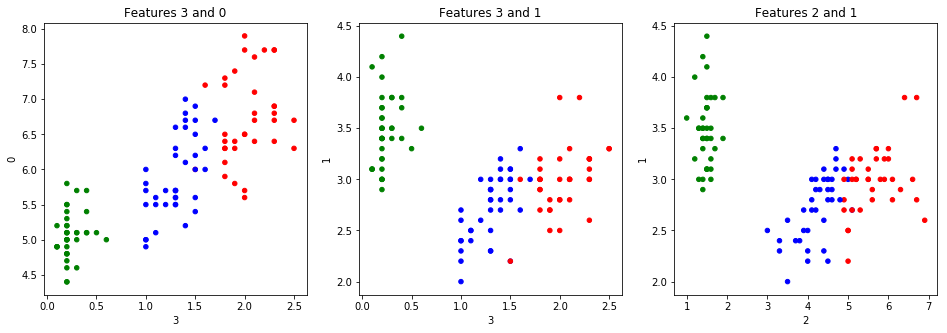

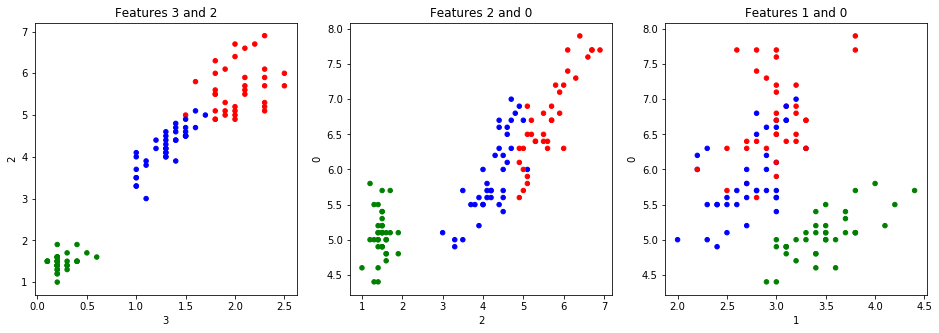

In [792]:
fig1, ax1 = plt.subplots(ncols=3)
fig2, ax2 = plt.subplots(ncols=3)
category_map = {'Iris-virginica': 'red', 'Iris-versicolor': 'blue', 'Iris-setosa': 'green'}
df.plot.scatter(x='3', y='0', color=[category_map.get(label, 'black') for label in df.labels], ax=ax1[0], title="Features 3 and 0")
df.plot.scatter(x='3', y='1', color=[category_map.get(label, 'black') for label in df.labels], ax=ax1[1], title="Features 3 and 1")
df.plot.scatter(x='2', y='1', color=[category_map.get(label, 'black') for label in df.labels], ax=ax1[2], title="Features 2 and 1")
df.plot.scatter(x='3', y='2', color=[category_map.get(label, 'black') for label in df.labels], ax=ax2[0], title="Features 3 and 2")
df.plot.scatter(x='2', y='0', color=[category_map.get(label, 'black') for label in df.labels], ax=ax2[1], title="Features 2 and 0")
df.plot.scatter(x='1', y='0', color=[category_map.get(label, 'black') for label in df.labels], ax=ax2[2], title="Features 1 and 0")


## Normalization
Let's normalize the data. Normalization is only done on the inputs

We need to convert our DataFrame into a numpy array first

In [793]:
# Convert Pandas DataFrame to numpy array, ignoring the index
iris_data = df_clean.values
assert iris_data.shape == df_clean.shape
print("Shape: ", iris_data.shape)
print(iris_data[:5]) # First 5 values

Shape:  (110, 5)
[[6.3 2.9 5.6 1.8 'Iris-virginica']
 [5.6 3.0 4.5 1.5 'Iris-versicolor']
 [7.9 3.8 6.4 2.0 'Iris-virginica']
 [6.5 2.8 4.6 1.5 'Iris-versicolor']
 [5.0 2.0 3.5 1.0 'Iris-versicolor']]


Now we can get the inputs X (features) and outputs Y (labels)

In [794]:
X_data = df_clean.drop(columns=['labels']).values # inputs
Y_labels = df_clean.filter(['labels']) # labels
Y_dummies = pd.get_dummies(Y_labels, columns=['labels'])
categories = pd.Series(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa']).astype('category')
Y_data = Y_dummies.values
M, features = X_data.shape # number of features and number of inputs / examples
assert X_data.shape == (df_clean.shape[0], df_clean.shape[1]-1)
assert Y_data.shape == (110, 3)
print("X: ", X_data[:2])
print("Y: ", Y_data[:5])
categories

X:  [[ 6.3  2.9  5.6  1.8]
 [ 5.6  3.   4.5  1.5]]
Y:  [[0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]]


0     Iris-virginica
1    Iris-versicolor
2        Iris-setosa
dtype: category
Categories (3, object): [Iris-setosa, Iris-versicolor, Iris-virginica]

In [795]:
def normalize_inputs(X):
    X_norm = np.array(X)
    X_norm /= np.max(np.abs(X_norm),axis=(0, 1))
    return X_norm

In [796]:
X_norm = normalize_inputs(X_data)
print(X_norm[:3])

[[ 0.79746835  0.36708861  0.70886076  0.2278481 ]
 [ 0.70886076  0.37974684  0.56962025  0.18987342]
 [ 1.          0.48101266  0.81012658  0.25316456]]


Let's visualize that again, but only for features 0 and 3 

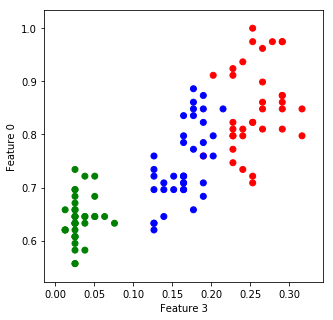

In [797]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.scatter(x=X_norm[:,3], y=X_norm[:,0], color=[category_map.get(label, 'black') for label in df.labels])
plt.ylabel("Feature 0")
plt.xlabel("Feature 3")
plt.show()


Looks good.

Now, to allocate Train, Dev and Test Sets at `60:20:20` ratio

In [798]:
r1, r2 = int(0.6 * M), int(0.2 * M)
X_train, X_dev, X_test = X_norm[:r1,:], X_norm[-(2*r2):-r2,:], X_norm[-r2:,:]
Y_train, Y_dev, Y_test = Y_data[:r1, :], Y_data[-(2*r2):-r2,:], Y_data[-r2:,:]


assert X_train.shape == (r1, features)
assert X_dev.shape == (r2, features)
assert X_test.shape == (r2, features)
assert Y_train.shape == (r1, 3)
assert Y_dev.shape == (r2, 3)
assert Y_test.shape == (r2, 3)

In [799]:
num_hidden_nodes = [5, 10, 20]  
learning_rate = 0.005
loss_plot = {5: [], 10: [], 20: []}  
weights1 = {5: None, 10: None, 20: None} 
biases1 = {5: None, 10: None, 20: None}  
weights2 = {5: None, 10: None, 20: None}  
biases2 = {5: None, 10: None, 20: None}  
num_iters = 2000

Create the training model

In [800]:
def create_train_model(hidden_nodes, num_iters, learning_rate=0.005, interval=50):

    # Reset the graph
    tf.reset_default_graph()

    # Placeholders for input and output data
    X = tf.placeholder(shape=(None, 4), dtype=tf.float64, name='X')
    Y = tf.placeholder(shape=(None, 3), dtype=tf.float64, name='y')

    # Variables for two group of weights between the three layers of the network
    W1 = tf.Variable(np.random.rand(features, hidden_nodes))
    b1 = tf.Variable(np.random.rand(1,hidden_nodes)) # Bias group 1
    W2 = tf.Variable(np.random.rand(hidden_nodes, 3))
    b2 = tf.Variable(np.random.rand(1,3)) # Bias group 2

    # Create the neural net graph
    A1 = tf.nn.relu(tf.add(tf.matmul(X, W1),b1))
    Y_est = tf.nn.softmax(tf.add(tf.matmul(A1, W2),b2))

    # Define a loss function
    loss = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(Y_est), axis=0))
    

    # Define a train operation to minimize the loss
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)

    # Initialize variables and run session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    # Go through num_iters iterations
    for i in range(num_iters):
        sess.run([train], feed_dict={X: X_train, Y: Y_train})
        sess_loss = sess.run(loss, feed_dict={X: np.asmatrix(X_train), Y: np.asmatrix(Y_train)})
        loss_plot[hidden_nodes].append(sess_loss)
        weights1 = sess.run(W1)
        weights2 = sess.run(W2)
        if i % interval == 0:
           print("loss (hidden nodes: %d, iterations: %d): %.2f" % (hidden_nodes, interval + i, loss_plot[hidden_nodes][-1]))
    
    parameters = {
        'W1': weights1,
        'b1': b1.eval(session=sess),
        'W2': weights2,
        'b2': b2.eval(session=sess)
    }
    sess.close()
    return parameters

loss (hidden nodes: 5, iterations: 1000): 26.90
loss (hidden nodes: 5, iterations: 2000): 2.64
loss (hidden nodes: 5, iterations: 3000): 1.57
loss (hidden nodes: 10, iterations: 1000): 23.12
loss (hidden nodes: 10, iterations: 2000): 2.30
loss (hidden nodes: 10, iterations: 3000): 1.44
loss (hidden nodes: 20, iterations: 1000): 27.67
loss (hidden nodes: 20, iterations: 2000): 2.22
loss (hidden nodes: 20, iterations: 3000): 1.39


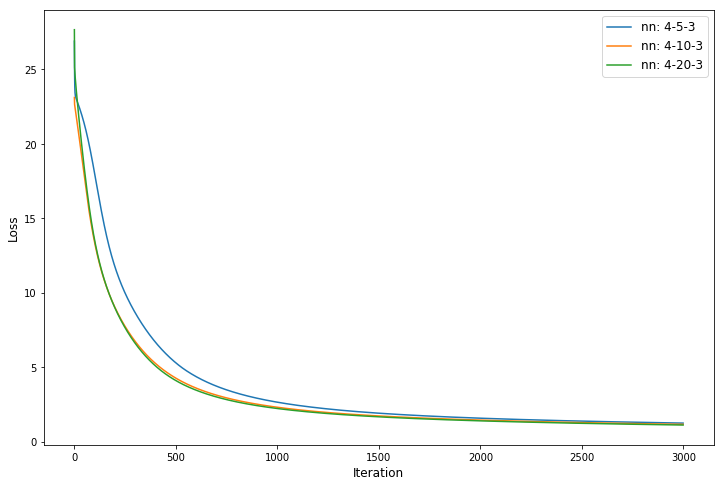

In [801]:
# Plot the loss function over iterations
num_hidden_nodes = [5, 10, 20]  
loss_plot = {5: [], 10: [], 20: []}  
weights1 = {5: None, 10: None, 20: None} 
biases1 = {5: None, 10: None, 20: None}  
weights2 = {5: None, 10: None, 20: None}  
biases2 = {5: None, 10: None, 20: None}  
num_iters = 3000

plt.figure(figsize=(12,8))  
for hidden_nodes in num_hidden_nodes:  
    parameters = create_train_model(hidden_nodes, num_iters, interval=1000)
    (weights1[hidden_nodes],
     weights2[hidden_nodes],
     biases1[hidden_nodes],
     biases2[hidden_nodes]) = (parameters['W1'],
                          parameters['W2'],
                          parameters['b1'],
                          parameters['b2']) 
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 4-%d-3" % hidden_nodes)

plt.xlabel('Iteration', fontsize=12)  
plt.ylabel('Loss', fontsize=12)  
plt.legend(fontsize=12)  


Let's evaluate the models on the dev set

In [802]:
def get_predictions(hidden_nodes, X_test):
    # Reset the graph
    tf.reset_default_graph()
    
    X_ = tf.placeholder(shape=(None, 4), dtype=tf.float64, name='X_')
    Y_ = tf.placeholder(shape=(None, 3), dtype=tf.float64, name='Y_')
    W1_ = tf.Variable(weights1[hidden_nodes], name='W1_')
    W2_ = tf.Variable(weights2[hidden_nodes], name='W2_')
    b1_ = tf.Variable(biases1[hidden_nodes], dtype=tf.float64, name='b1_')
    b2_ = tf.Variable(biases2[hidden_nodes], dtype=tf.float64, name='b2_')
    
    A1_ = tf.nn.relu(tf.matmul(X_, W1_) + b1_)
    Y_est_ = tf.nn.softmax(tf.matmul(A1_, W2_) + b2_)
    
    predictions = []
    
    # Initialize variables and run session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    predictions = np.rint(sess.run(Y_est_, feed_dict={X_: X_test}))
    predictions = np.array(predictions).astype(int)
    
    sess.close()
    return predictions

In [803]:
# Predictions on dev set
for hidden_nodes in num_hidden_nodes: # For testing different architectures
    predictions = get_predictions(hidden_nodes, X_dev)
    accuracy = (predictions == Y_dev).all(axis=1).mean()
    print('Network architecture 4-{}-3: \nAccuracy: {}'.format(hidden_nodes, accuracy))


Network architecture 4-5-3: 
Accuracy: 1.0
Network architecture 4-10-3: 
Accuracy: 1.0
Network architecture 4-20-3: 
Accuracy: 1.0


All the above architectures seem up to the task. We'll select the simplest one - `4-5-3`

In [804]:
# Predictions on test set
hidden_nodes = 5
predictions = get_predictions(hidden_nodes, X_test)
accuracy = (predictions == Y_test).all(axis=1).mean()
print('Network architecture 4-{}-3: \nAccuracy: {}'.format(hidden_nodes, accuracy))


Network architecture 4-5-3: 
Accuracy: 1.0


### Labelling Unlabelled data

In [805]:
get_labels = np.array(pd.Series(Y_dummies.columns[np.where(Y_dummies!=0)[1]]))
test_df = pd.read_csv('data/iris_test.csv')
print("Shape: ", df.shape)
print("Columns: ", df.columns)
print("Labels: ", df.labels.unique())
test_df.head(5)

Shape:  (110, 6)
Columns:  Index(['Unnamed: 0', '0', '1', '2', '3', 'labels'], dtype='object')
Labels:  ['Iris-virginica' 'Iris-versicolor' 'Iris-setosa']


,Unnamed: 0,0,1,2,3
0,0,7.2,3.6,6.1,2.5
1,1,4.7,3.2,1.3,0.2
2,2,4.4,3.2,1.3,0.2
3,3,4.5,2.3,1.3,0.3
4,4,6.4,3.2,4.5,1.5


In [806]:
test_df_clean = test_df.drop(columns=['Unnamed: 0'])
test_df_clean.head(2)

,0,1,2,3
0,7.2,3.6,6.1,2.5
1,4.7,3.2,1.3,0.2


In [807]:
X_test_data = test_df_clean.values # inputs
X_test_data[:2]

array([[ 7.2,  3.6,  6.1,  2.5],
       [ 4.7,  3.2,  1.3,  0.2]])

Let's normalize the test data

In [808]:
X_test_norm = normalize_inputs(X_test_data)
X_test_norm[:2]

array([[ 1.        ,  0.5       ,  0.84722222,  0.34722222],
       [ 0.65277778,  0.44444444,  0.18055556,  0.02777778]])

Now to vizualize the test data

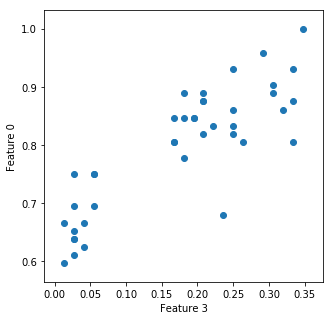

In [809]:
plt.scatter(x=X_test_norm[:,3], y=X_test_norm[:,0])
plt.ylabel("Feature 0")
plt.xlabel("Feature 3")
plt.show()

It's clear that the test data has all three type of flowers. Let's label them!

In [810]:
# Predictions on test data
hidden_nodes = 5
test_predictions = get_predictions(hidden_nodes, X_test_norm)
test_predictions = tuple(map(tuple, test_predictions))
print("Predictions: ", test_predictions)


Predictions:  ((0, 0, 1), (1, 0, 0), (1, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 0), (0, 0, 1), (0, 1, 0), (0, 0, 1), (0, 1, 0), (0, 0, 1), (0, 0, 1), (0, 1, 0), (0, 1, 0), (1, 0, 0), (0, 0, 1), (0, 0, 1), (0, 0, 1), (0, 0, 1), (1, 0, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1), (1, 0, 0), (0, 0, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, 1), (0, 1, 0), (0, 0, 1), (1, 0, 0), (1, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0))


Let's plot the labelled points

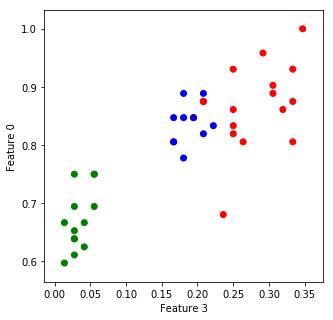

In [811]:
category_labels = {(0, 0, 1):'Iris-virginica', (0, 1, 0):'Iris-versicolor', (1, 0, 0):'Iris-setosa'} # Inital mappings
category_map_2 = {(0, 0, 1): 'red', (0, 1, 0): 'blue', (1, 0, 0): 'green'}

plt.scatter(x=X_test_norm[:,3], y=X_test_norm[:,0],
            color=[category_map_2.get(pred, 'black') for pred in test_predictions])
plt.ylabel("Feature 0")
plt.xlabel("Feature 3")
# plt.legend()
plt.show()

Hmm... It seems we **might** have mislabelled a versicolor as virginica. But that's just one dimension, so it should be fine.

Let's populate the submissions file. But first, we convert the predictions to actual labels, then to a pandas DataFrame

In [812]:
test_prediction_labels = [category_labels.get(pred) for pred in test_predictions]    
pd_test_predictions = pd.DataFrame({4: test_prediction_labels})
pd_test_predictions.head(3)

,4
0,Iris-virginica
1,Iris-setosa
2,Iris-setosa


Send it over to the CSV file!

In [813]:
pd_test_predictions.to_csv('submissions/iris_actual_submission.csv', encoding='utf-8')